In [1]:
# Import relevant libraries
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from matplotlib import colors
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning, PolicyIterationModified
import random
from timeit import default_timer as timer
from datetime import timedelta
import time
import copy
# Set the random seed
np.random.seed(42)

In [287]:
# Set up helper functions
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'r',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title ='Frozen Lake 4x4'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.show()
    
def plot_lake_values(env, policy=None, title ='Frozen Lake 4x4'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, "{:.4f}".format(policy[i, j]),
                               horizontalalignment='center', size=15, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.show()
    
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                #print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                #print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    return ave_steps, std_steps, pct_fail

In [5]:
# Define a custom map for 16x16 grid world
MAPS = {
    "4x4": [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
    ],
    
    "16x16": [
    "SFFFFFFHFFFHHFFF",
    "FFFFFFFFFFFFFFFF",
    "FHHHFFFFFFFHFFFF",
    "FFHFHHFHFFFFFFHF",
    "FFFHFHFFFHFFFFFF",
    "HFFFFFFFHFFFFFFF",
    "FFFFFFFFHFFFFFFF",
    "HHFHHFHFHHFFFFHH",
    "FFFFFFHFFFFHHFFF",
    "FFFFFFHFFFHFFFFF",
    "FFFFFHFFFFFFFFFF",
    "FFHFFFHHFFHFFFFH",
    "HFFFFHHFFFFHFFFF",
    "FFFFFFFFFFFHFFFF",
    "FFHFHFFFFFFFFFFF",
    "HHHFFHFHHHFFHFFG",
    ]
}

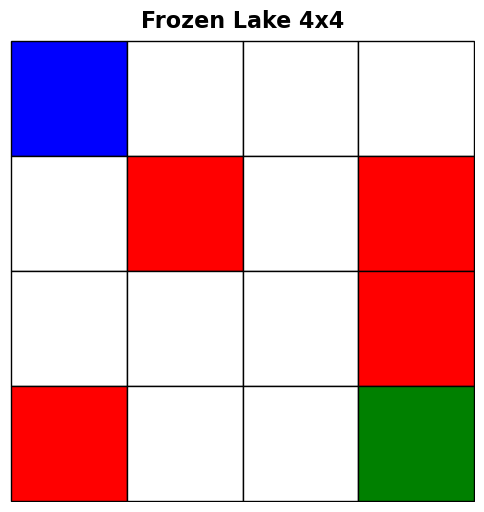

In [118]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True).unwrapped
# Need to change the values based on number of rows and columns

rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]

In [119]:
def trainVI(P, R, discount=0.9, epsilon=[1e-9]):
    vi_df = pd.DataFrame(columns=["Epsilon", 'Discount', "Policy", "Iteration", 
                                  "Time", "Reward",
                                  "Value Function",'Avg_Steps','Steps_StDev','Success_Rate'
                                 ])
    vi_run_full = pd.DataFrame()

    for gamma in discount:
        for eps in epsilon:
            vi = ValueIteration(P, R, gamma=gamma, epsilon=eps, max_iter=int(1e15))
            vi_run, vi_policy = vi.run()
            vi_run_df = pd.DataFrame(vi_run)
            vi_run_df['Eps'] = str(float(eps))
            vi_run_df['Gamma'] = str(float(gamma))

            reward = max(vi_run_df['Reward'])
            steps, steps_stddev, failures = get_score(env, vi.policy, None)
            info = [float(eps),float(gamma), vi.policy, vi.iter, vi.time, reward,
                    vi.V, steps,steps_stddev,
                    # Success is 100% - failure%
                    100-failures]
            df_length = len(vi_df)
            vi_df.loc[df_length] = info
                    
            vi_run_full = pd.concat([vi_run_full,vi_run_df])
            
    return vi_df, vi_policy, vi_run,vi,vi_run_full

In [120]:
%%time
discount= [0.5,0.75,0.9,0.99]
epsilon=[1e-3,1e-5,1e-7]

vi_df,vi_policy,vi_run,vi,vi_run_full = trainVI(T, R, discount= discount, epsilon=epsilon)
df = pd.DataFrame(vi_run)
vi_df

Wall time: 5.19 s


,Epsilon,Discount,Policy,Iteration,Time,Reward,Value Function,Avg_Steps,Steps_StDev,Success_Rate
0,1.000000e-03,0.50,"(1, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",7,0.001001,0.405569,"(-0.01983910608139003, -0.020275634430727017, ...",94.100728,91.751634,82.4
1,1.000000e-05,0.50,"(1, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",13,0.000000,0.405784,"(-0.019924134275040348, -0.020422376657262004,...",90.058542,82.922818,83.7
2,1.000000e-07,0.50,"(1, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",18,0.000997,0.405785,"(-0.019924656272541516, -0.02042379755525777, ...",91.515075,79.984458,79.6
3,1.000000e-03,0.75,"(1, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",15,0.000000,0.489462,"(-0.03652112467835346, -0.04049296545485655, -...",92.263409,90.517508,83.9
4,1.000000e-05,0.75,"(1, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",28,0.000996,0.489606,"(-0.03662475852788883, -0.04074999422161053, -...",95.086313,86.956031,81.1
5,1.000000e-07,0.75,"(1, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",42,0.001992,0.489606,"(-0.03662767803739446, -0.04075419323336178, -...",90.156962,86.280075,79.0
6,1.000000e-03,0.90,"(1, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",36,0.001505,0.589012,"(-0.06581242087661196, -0.08577578475471018, -...",92.048603,87.320224,82.3
7,1.000000e-05,0.90,"(1, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",74,0.002990,0.589012,"(-0.0663211861301162, -0.08639144876971382, -0...",93.056581,92.747547,81.3
8,1.000000e-07,0.90,"(1, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",113,0.005291,0.589012,"(-0.06632763674507582, -0.08639867755957671, -...",93.087515,89.876919,85.7
9,1.000000e-03,0.99,"(0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)",192,0.006976,0.715865,"(0.005002284616738614, -0.09223682888212507, -...",49.614268,43.219945,82.7


In [224]:
vi_score_df = pd.DataFrame()
vi_score_df_full = pd.DataFrame()
for i in range(0,5):
    vi_df,vi_policy,vi_run,vi,vi_run_full = trainVI(T, R, discount= discount, epsilon=epsilon)
    vi_score_df = vi_df[['Epsilon','Discount','Success_Rate']]
    vi_score_df = vi_score_df.rename(columns={'Success_Rate':'Success_Rate_'+str(i)})
    vi_score_df_full = pd.concat([vi_score_df_full,vi_score_df],axis=1)

In [225]:
vi_score_df_full = vi_score_df_full.loc[:,~vi_score_df_full.columns.duplicated()].copy()

In [241]:
vi_score_df_full['Success_Mean'] = vi_score_df_full.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].mean(axis = 1)
vi_score_df_full['Success_StdDev'] = vi_score_df_full.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].std(axis = 1)
vi_score_df_full['Success_Max'] = vi_score_df_full.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].max(axis = 1)

In [284]:
vi_score_df_full

,Epsilon,Discount,Success_Rate_0,Success_Rate_1,Success_Rate_2,Success_Rate_3,Success_Rate_4,Success_Mean,Success_StdDev,Success_Max
0,1.000000e-03,0.50,82.6,84.2,82.7,79.8,79.5,81.76,2.030517,84.2
1,1.000000e-05,0.50,83.1,82.0,82.1,83.7,82.9,82.76,0.712741,83.7
2,1.000000e-07,0.50,82.0,83.4,82.0,80.0,80.2,81.52,1.418450,83.4
3,1.000000e-03,0.75,82.7,81.9,84.5,83.4,83.1,83.12,0.954987,84.5
4,1.000000e-05,0.75,83.6,80.4,82.4,81.7,84.3,82.48,1.541752,84.3
5,1.000000e-07,0.75,81.1,82.4,80.1,80.9,82.1,81.32,0.933809,82.4
6,1.000000e-03,0.90,83.5,83.7,82.0,82.2,80.8,82.44,1.188697,83.7
7,1.000000e-05,0.90,82.9,81.5,83.5,81.6,84.7,82.84,1.344619,84.7
8,1.000000e-07,0.90,83.7,81.7,82.2,80.8,82.3,82.14,1.054988,83.7
9,1.000000e-03,0.99,82.7,84.6,83.0,81.9,82.6,82.96,1.001499,84.6


In [263]:
a1 = vi_score_df_full[vi_score_df_full['Epsilon']==1.e-07]
a2 = vi_score_df_full[vi_score_df_full['Epsilon']==1.e-05]
a3 = vi_score_df_full[vi_score_df_full['Epsilon']==1.e-03]

,Epsilon,Discount,Success_Rate_0,Success_Rate_1,Success_Rate_2,Success_Rate_3,Success_Rate_4,Success_Mean,Success_StdDev,Success_Max
2,1.000000e-07,0.50,82.0,83.4,82.0,80.0,80.2,81.52,1.418450,83.4
5,1.000000e-07,0.75,81.1,82.4,80.1,80.9,82.1,81.32,0.933809,82.4
8,1.000000e-07,0.90,83.7,81.7,82.2,80.8,82.3,82.14,1.054988,83.7
11,1.000000e-07,0.99,82.2,83.7,81.3,83.4,82.8,82.68,0.962808,83.7


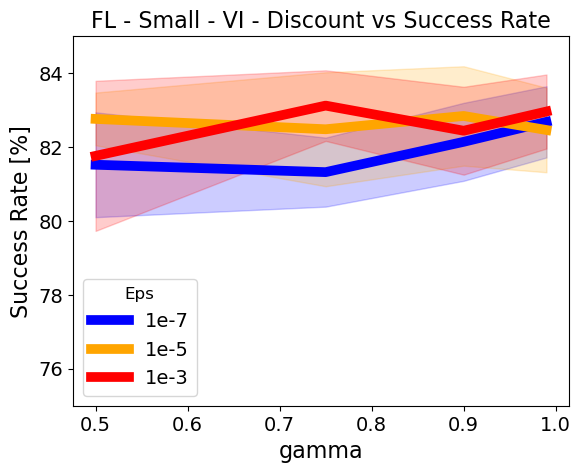

In [273]:
plt.plot(a1['Discount'],a1['Success_Mean'],linewidth =7,color="blue", label='1e-7')
plt.fill_between(a1['Discount'], a1['Success_Mean']+a1['Success_StdDev'],a1['Success_Mean']-a1['Success_StdDev'], alpha=0.2, color="blue")


plt.plot(a2['Discount'],a2['Success_Mean'],linewidth =7,color="orange", label='1e-5')
plt.fill_between(a2['Discount'], a2['Success_Mean']+a2['Success_StdDev'],a2['Success_Mean']-a2['Success_StdDev'], alpha=0.2, color="orange")

plt.plot(a3['Discount'],a3['Success_Mean'],linewidth =7,color="red", label='1e-3')
plt.fill_between(a3['Discount'], a3['Success_Mean']+a3['Success_StdDev'],a3['Success_Mean']-a3['Success_StdDev'], alpha=0.2, color="red")


plt.xlabel('gamma',fontsize = 16)
plt.ylabel('Success Rate [%]',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(75,85)
plt.title('FL - Small - VI - Discount vs Success Rate', fontsize=16)
# plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.legend(title="Eps",title_fontsize=12, loc="best",prop={'size': 14})

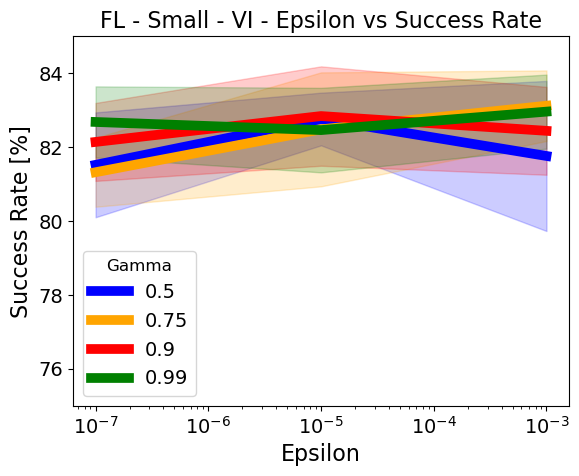

In [279]:
b1 = vi_score_df_full[vi_score_df_full['Discount']==0.5]
b2 = vi_score_df_full[vi_score_df_full['Discount']==0.75]
b3 = vi_score_df_full[vi_score_df_full['Discount']==0.9]
b4 = vi_score_df_full[vi_score_df_full['Discount']==0.99]


plt.plot(b1['Epsilon'],b1['Success_Mean'],linewidth =7,color="blue", label='0.5')
plt.fill_between(b1['Epsilon'], b1['Success_Mean']+b1['Success_StdDev'],b1['Success_Mean']-b1['Success_StdDev'], alpha=0.2, color="blue")


plt.plot(b2['Epsilon'],b2['Success_Mean'],linewidth =7,color="orange", label='0.75')
plt.fill_between(b2['Epsilon'], b2['Success_Mean']+b2['Success_StdDev'],b2['Success_Mean']-b2['Success_StdDev'], alpha=0.2, color="orange")

plt.plot(b3['Epsilon'],b3['Success_Mean'],linewidth =7,color="red", label='0.9')
plt.fill_between(b3['Epsilon'], b3['Success_Mean']+b3['Success_StdDev'],b3['Success_Mean']-b3['Success_StdDev'], alpha=0.2, color="red")

plt.plot(b4['Epsilon'],b4['Success_Mean'],linewidth =7,color="green", label='0.99')
plt.fill_between(b4['Epsilon'], b4['Success_Mean']+b4['Success_StdDev'],b4['Success_Mean']-b4['Success_StdDev'], alpha=0.2, color="green")


plt.xlabel('Epsilon',fontsize = 16)
plt.ylabel('Success Rate [%]',fontsize = 16)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(75,85)
plt.title('FL - Small - VI - Epsilon vs Success Rate', fontsize=16)
plt.legend(title="Gamma",title_fontsize=12, loc="best",prop={'size': 14})

In [142]:
vi_df_05_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.5']))]
vi_df_05_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.5']))]
vi_df_05_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.5']))]

vi_df_075_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.75']))]
vi_df_075_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.75']))]
vi_df_075_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.75']))]

vi_df_09_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.9']))]
vi_df_09_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.9']))]
vi_df_09_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.9']))]

vi_df_099_e3 = vi_run_full[(vi_run_full['Eps'].isin(['0.001'])) &(vi_run_full['Gamma'].isin(['0.99']))]
vi_df_099_e5 = vi_run_full[(vi_run_full['Eps'].isin(['1e-05'])) &(vi_run_full['Gamma'].isin(['0.99']))]
vi_df_099_e7 = vi_run_full[(vi_run_full['Eps'].isin(['1e-07'])) &(vi_run_full['Gamma'].isin(['0.99']))]

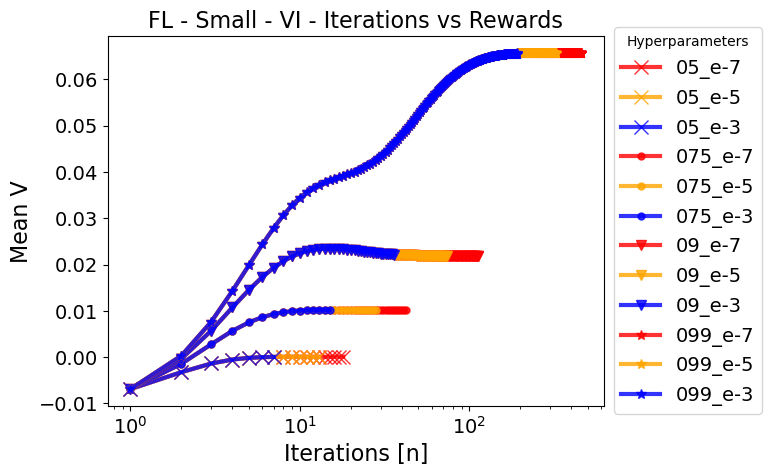

In [291]:
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')
plt.plot(vi_df_05_e5['Iteration'],vi_df_05_e5['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='05_e-5')
plt.plot(vi_df_05_e3['Iteration'],vi_df_05_e3['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='05_e-3')

plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='075_e-7')
plt.plot(vi_df_075_e5['Iteration'],vi_df_075_e5['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-5')
plt.plot(vi_df_075_e3['Iteration'],vi_df_075_e3['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'b', label='075_e-3')

plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='09_e-7')
plt.plot(vi_df_09_e5['Iteration'],vi_df_09_e5['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='09_e-5')
plt.plot(vi_df_09_e3['Iteration'],vi_df_09_e3['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='09_e-3')

plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'red', label='099_e-7')
plt.plot(vi_df_099_e5['Iteration'],vi_df_099_e5['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'orange', label='099_e-5')
plt.plot(vi_df_099_e3['Iteration'],vi_df_099_e3['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'b', label='099_e-3')


plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FL - Small - VI - Iterations vs Rewards', size =16)
plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.xscale('log')

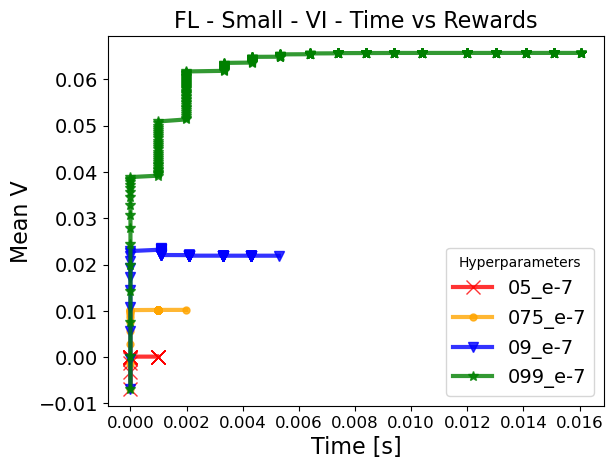

In [293]:
plt.plot(vi_df_05_e7['Time'],vi_df_05_e7['Mean V'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')
plt.plot(vi_df_075_e7['Time'],vi_df_075_e7['Mean V'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7')
plt.plot(vi_df_09_e7['Time'],vi_df_09_e7['Mean V'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7')
plt.plot(vi_df_099_e7['Time'],vi_df_099_e7['Mean V'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7')


plt.xlabel("Time [s]",fontsize = 16)
plt.ylabel("Mean V",fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.title('FL - Small - VI - Time vs Rewards', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})

(0.0, 0.006)

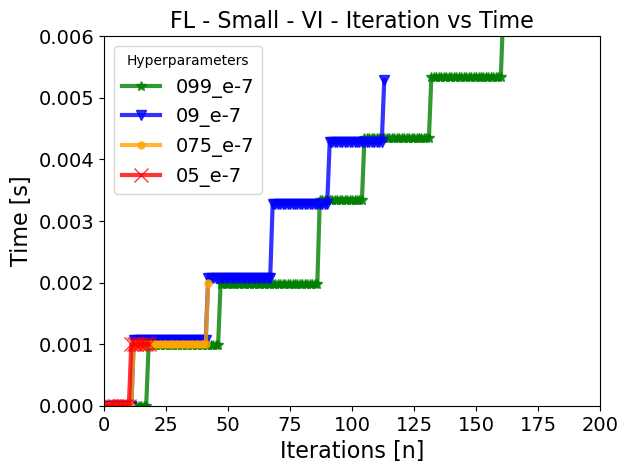

In [295]:
plt.plot(vi_df_099_e7['Iteration'],vi_df_099_e7['Time'], '*-', markersize=7, alpha =0.8, linewidth =3, color= 'green', label='099_e-7')
plt.plot(vi_df_09_e7['Iteration'],vi_df_09_e7['Time'], 'v-', markersize=7, alpha =0.8, linewidth =3, color= 'blue', label='09_e-7')
plt.plot(vi_df_075_e7['Iteration'],vi_df_075_e7['Time'], '.-', markersize=10, alpha =0.8, linewidth =3, color= 'orange', label='075_e-7')
plt.plot(vi_df_05_e7['Iteration'],vi_df_05_e7['Time'], 'x-', markersize=10, alpha =0.8, linewidth =3, color= 'red', label='05_e-7')

plt.xlabel("Iterations [n]",fontsize = 16)
plt.ylabel("Time [s]",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('FL - Small - VI - Iteration vs Time', size =16)
plt.legend(title="Hyperparameters", loc="best",prop={'size': 14})
plt.xlim(0,200)
plt.ylim(0,0.006)

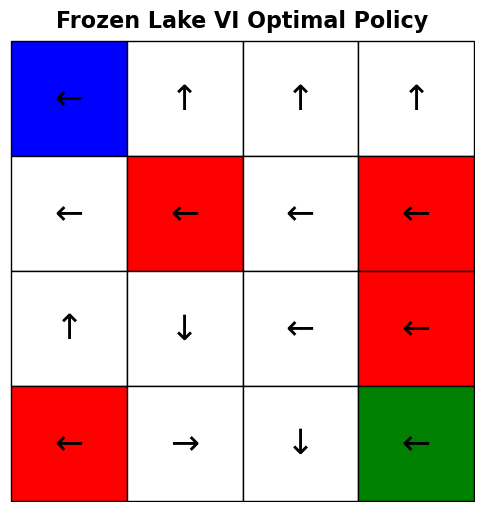

In [286]:
best_policy = np.array(list(vi_df.loc[11]["Policy"]))
best_policy = best_policy.reshape(rows, cols)
title='Frozen Lake VI Optimal Policy'
plot_lake(env, best_policy, title='Frozen Lake VI Optimal Policy')

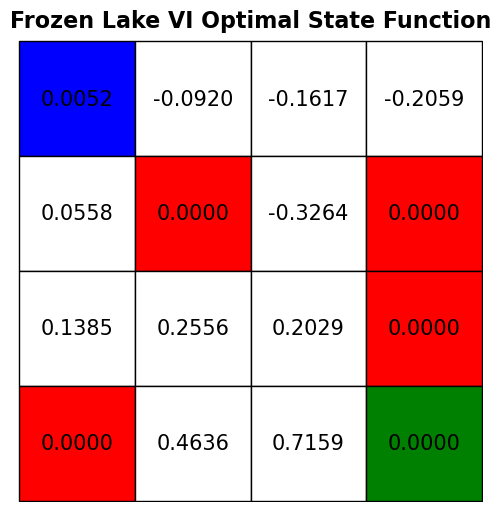

In [289]:
best_val_fn = np.array(list(vi_df.loc[11]["Value Function"]))
best_val_fn = best_val_fn.reshape(rows, cols)
plot_lake_values(env, best_val_fn, title='Frozen Lake VI Optimal State Function')